# DENA aviation GPS points $\rightarrow$ NMSIM trajectories

Davyd_Betchkal@nps.gov ◘ 2020-10-29

In [20]:
# some very standard libraries
import sys
import datetime as dt
import os
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import UnivariateSpline

# geoprocessing libraries
import fiona
from fiona.crs import from_epsg
import pyproj
import geopandas as gpd
from shapely.ops import transform
from shapely.geometry import mapping, Point, Polygon

# load the DENA query tracks script
sys.path.append(r"D:\overflights\scripts")
from query_tracks import query_tracks

# load iyore
sys.path.append(r"C:\Users\ahug\Documents\PythonScripts\iyore")
import iyore


# ===========================  define functions  =======================================

def get_utm_zone(longitude):
    
    return (int(1+(longitude+180.0)/6.0))

def climb_angle(v):
    
    """
    compute the 'climb angle' of a vector
    A = 𝑛•𝑏=|𝑛||𝑏|𝑠𝑖𝑛(𝜃)
    """
    
    # a unit normal vector perpendicular to the xy plane
    n = np.array([0,0,1])
    
    degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))
    return degrees

def point_buffer(lat, lon, km):
    
    wgs84 = pyproj.Proj(init='epsg:4326')

    # Azimuthal equidistant projection
    aeqd_formatter = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    aeqd = pyproj.Proj(aeqd_formatter.format(lat=lat, lon=lon))

    # project the site coordinate into aeqd
    long_m, lat_m = pyproj.transform(wgs84, aeqd, lon, lat)

    # buffer using a radius in meters
    buf_m = Point(long_m, lat_m).buffer(km * 1000)  # distance in metres

    # this will convert polygons from aeqd back into wgs84
    projector = partial(pyproj.transform, aeqd, wgs84)

    buf = transform(projector, buf_m)  # apply projection

    return buf


def tracks_within(ds, site, year, search_within_km = 20, climb_ang_max = 20, aircraft_specs=False, clip=False, altOut=None):
    
    unit = "DENA"
    
    # ===== first part; site coordinate wrangling =====================
    
    # load the metadata sheet
    metadata = pd.read_csv(r"V:\Complete_Metadata_AKR_2001-2020.txt", delimiter="\t", encoding = "ISO-8859-1")

    # look up the site's coordinates in WGS84
    lat_in, long_in = metadata.loc[(metadata["code"] == site)&(metadata["year"] == year), "lat":"long"].values[0]

    # lookup the UTM zone using the first point
    zone = get_utm_zone(long_in)

    # epsg codes for Alaskan UTM zones
    epsg_lookup = {1:'epsg:26901', 2:'epsg:26902', 3:'epsg:26903', 4:'epsg:26904', 5:'epsg:26905', 
                   6:'epsg:26906', 7:'epsg:26907', 8:'epsg:26908', 9:'epsg:26909', 10:'epsg:26910'}

    # convert from D.d (WGS84) to meters (NAD83)
    in_proj = pyproj.Proj(init='epsg:4326')
    out_proj = pyproj.Proj(init=epsg_lookup[zone])

    # convert into NMSIM's coordinate system
    long, lat = pyproj.transform(in_proj, out_proj, long_in, lat_in)


    # ===== second part; mic height to feet =====================

    # look up the site's coordinates in WGS84
    height = metadata.loc[(metadata["code"] == site)&(metadata["year"] == year), "microphone_height"].values[0]

    print(unit+site+str(year)+":", "{0:.0f},".format(long), "{0:.0f}".format(lat), "- UTM zone", zone)
    print("\tmicrophone height", "{0:.2f} feet.".format(height*3.28084))


    # ===== third part; save mask file using the buffer radius of choice ===============

    # create the buffer polygon
    buf = point_buffer(lat_in, long_in, search_within_km)  

    # Define a polygon feature geometry with one attribute
    schema = {'geometry': 'Polygon', 'properties': {'id': 'int'},}

    # write a new shapefile with the buffered polygon
    with fiona.open('site_buf.shp', 'w', 'ESRI Shapefile', schema, crs=from_epsg(4326)) as c:
        
        ## If there are multiple geometries, put the "for" loop here
        c.write({'geometry': mapping(buf),'properties': {'id': 0},})

    print("\n\tShapefile containing " + str(search_within_km)+"km radius buffer has been written!")
    
    # plot the buffer within the park boundary
    buffer_path = r"C:\Users\ahug\Documents\PythonScripts\site_buf.shp"
    DENA_outline_path = r"T:\ResMgmt\WAGS\Sound\GIS\Denali\DENA_outline.shp"
    gpd_buffer = gpd.read_file(buffer_path)
    gpd_DENA = gpd.read_file(DENA_outline_path)
    base = gpd_buffer.plot(color='white', edgecolor='black')
    base.set_aspect(2)
    plt.show()
    

    # ===== fourth part; determine the date range of NVSPL files ===============

    # load the datetime of every NVSPL file
    NVSPL_dts = pd.Series([dt.datetime(year=int(e.year),
                                       month=int(e.month),
                                       day=int(e.day),
                                       hour=int(e.hour),
                                       minute=0,
                                       second=0) for e in ds.nvspl(unit=unit, site=site, year=year)])

    # everything should be in chronological order, but just in case...
    NVSPL_dts.sort_values(inplace=True, ascending=True)

    # retrieve the start/end bounds and convert back to YYYY-MM-DD strings
    start, end = (dt.datetime.strftime(d, "%Y-%m-%d") for d in [NVSPL_dts.iloc[0], NVSPL_dts.iloc[-1]])
    print("\n\tRecord begins", start, "and ends", end, "\n")
    
    # load tracks from the database over a certain daterange, using the buffered site
    tracks = query_tracks(connection_txt=r"D:\overflights\config\connection_info.txt", 
                          start_date=start, end_date=end, 
                          mask=gpd_buffer, clip_output=clip,
                          aircraft_info=aircraft_specs)
    
    # make a dataframe to hold distances and times
    closest_approaches = pd.DataFrame([], index=np.unique(tracks["id"]), columns=["closest_distance", "closest_time"])
    
    # process each unique flight track in sequence
    for f_id, data in tracks.groupby("flight_id"):
        
        if(len(data) > 1): # "one point does not a trajectory make"
        
            # double check that the data are sorted by time
            data = data.sort_values("ak_datetime")

            long_utm, lat_utm = pyproj.transform(in_proj, out_proj, data["longitude"].values, data["latitude"].values)

            # assign back into the dataframe for subsequent use
            data.loc[:, "long_UTM"] = long_utm
            data.loc[:, "lat_UTM"] = lat_utm

            # coordinates of each point
            coords = np.array([[lo, la, e] for lo, la, e in zip(data["long_UTM"], 
                                                                data["lat_UTM"], 
                                                                0.3048*data["altitude_ft"])])

            # convert the coordinates to vectors
            V = np.diff(coords, axis=0)

            # compute the climb angle for each point: 
            climb_angs = np.array([climb_angle(V[n]) for n in np.arange(len(V))])

            # if the climb angle is greater than 20° something strange is going on: reset to zero
            climb_angs[np.abs(climb_angs) > climb_ang_max] = 0

            # we don't know what the last point's angle should be, but NMSIM requires a value
            # just repeat the penultimate point's value
            climb_angs = np.append(climb_angs, climb_angs[-1])

            # assign the climb angles to the array
            data["ClimbAngle"] = climb_angs

            # NMSIM probably won't like nan... replace those with zero as well
            data["ClimbAngle"].fillna(0, inplace=True)

            # this is the start time of the track
            start = data["ak_datetime"].iloc[0]

            # truncate starting time to nearest hour to check against the NVSPL list
            check = start.replace(minute=0, second=0)

            # 1 if there is a match, 0 if not
            match_bool = NVSPL_dts.apply(lambda date: date in [check]).sum()

            if(match_bool == 0):

                tracks = tracks[tracks["flight_id"] != f_id]
                print("\t\t", "Flight starting", start, "has no matching acoustic record")

            elif(match_bool == 1):
                
                if(altOut is not None):

                    # make a folder for NMSIM .trj outputs
                    trj_out = altOut
                    if not os.path.exists(trj_out):
                        os.makedirs(trj_out)
                        
                else:
                    
                    # a path to the site's computational outputs folder
                    cOut = [e.path for e in ds.dataDir(unit=unit, site=site, year=year)][0] + \
                            os.sep + "02 ANALYSIS\Computational Outputs"
                    
                    # make a folder for NMSIM .trj outputs
                    trj_out = cOut + os.sep + "NMSIM_trj"
                    if not os.path.exists(trj_out):
                        os.makedirs(trj_out)

                # find the time at which the flight passes closest to the station
                site_coords = np.array([long, lat])
                GPSpoints_xy = np.array([data["long_UTM"], data["lat_UTM"]])

                # which point made the closest approach to the site?
                min_distance = np.min(np.linalg.norm(site_coords - GPSpoints_xy.T, axis=1))/1000

                # keep track of the closest approach by id
                closest_approaches.loc[data["flight_id"].iloc[0], "closest_distance"] = min_distance

                # at what time did the closest approach occur?
                closest_time = data.iloc[np.argmin(np.linalg.norm(site_coords - GPSpoints_xy.T, axis=1))]['ak_datetime']

                # likewise keep track of the closest time
                closest_approaches.loc[data["flight_id"].iloc[0], "closest_time"] = closest_time

                print("\t\t", "#"+str(f_id), "expected closest at", closest_time, "{0:0.1f}km".format(min_distance))

                # create a time-elapsed column
                data["time_elapsed"] = (data["ak_datetime"] - data["ak_datetime"].min()).apply(lambda t: t.total_seconds())

                # we'll only save the trajectory if it's within the specified search radius!
                if(min_distance <= search_within_km):

                    # ======= densify the GPS points for NMSIM ========

                    print("\n\t\t\t", "Flight is within search distance. Attempting to densify", 
                          data.shape[0], "points...")

                    new_points = gpd.GeoDataFrame([])
                    for row in data.itertuples():

                        try:

                            next_ind = data.index[np.argwhere(data.index == row.Index)+1][0][0]

                            # this represents time steps < 1 second
                            interpSteps = int(1.1*(data.loc[next_ind, "ak_datetime"] - row.ak_datetime).total_seconds())
                            print("trying for", interpSteps, "steps between points")

                            # interpolate the indices, longitudes, latitudes, and altitudes
                            # we don't need the first or last values - they're already in the dataframe
                            indi = np.linspace(row.Index, next_ind, interpSteps)[1:-1]
                            ti = np.linspace(row.time_elapsed, data.loc[next_ind, "time_elapsed"], interpSteps)[1:-1]
                            xi = np.linspace(row.longitude, data.loc[next_ind, "longitude"], interpSteps)[1:-1]
                            yi = np.linspace(row.latitude, data.loc[next_ind, "latitude"], interpSteps)[1:-1]
                            zi = np.linspace(row.altitude_ft, data.loc[next_ind, "altitude_ft"], interpSteps)[1:-1]
                            utm_xi = np.linspace(row.long_UTM, data.loc[next_ind, "long_UTM"], interpSteps)[1:-1]
                            utm_yi = np.linspace(row.lat_UTM, data.loc[next_ind, "lat_UTM"], interpSteps)[1:-1]
                            cai = np.linspace(row.ClimbAngle, data.loc[next_ind, "ClimbAngle"], interpSteps)[1:-1]
                            hi = np.linspace(row.heading, data.loc[next_ind, "heading"], interpSteps)[1:-1]
                            vi = np.linspace(row.knots, data.loc[next_ind, "knots"], interpSteps)[1:-1]

                            # generate geometry objects for each new interpolated point
                            gi = [Point(xyz) for xyz in zip(xi, yi, zi)]

                            # create a dictionary of the interpolated values to their column
                            d = {'time_elapsed': ti,
                                 'longitude': xi, 
                                 'latitude': yi,
                                 'altitude_ft': zi,
                                 'long_UTM': utm_xi,
                                 'lat_UTM': utm_yi,
                                 'ClimbAngle': cai,
                                 'heading': hi,
                                 'knots': vi,
                                 'geom': gi}


                            # turn the newly interpolated values into a GeoDataFrame 
                            rowsi = gpd.GeoDataFrame(d, index=indi, crs="EPSG:4326")

                            # append to the track's overall new points
                            new_points = new_points.append(rowsi)

                        # there is no next index on the last row... pass through
                        except IndexError:
                            pass


                    # append the new points and sort by index (which is also by time)
                    data = data.append(new_points)
                    data = data.sort_index()

                    print("\t\t\t", "...trajectory now has", 
                          data.shape[0], "points!\n")

                    # ======= write the trajectory file! ==============

                    print("\t\t\t", "Densification complete, writing trajectory file...")

                    # add N-number and begin time
                    start_time = dt.datetime.strftime(data["utc_datetime"].min(), "%Y-%m-%d %H:%M:%S")
                    file_name_dt = dt.datetime.strftime(data["utc_datetime"].min(), "_%Y%m%d_%H%M%S")
                    N_number = data["registration"].iloc[0]

                    # path to the specific .trj file to be written
                    trj_path = trj_out + os.sep + str(N_number) + str(file_name_dt) + ".trj"

                    with open(trj_path, 'w') as trajectory:

                        # write the header information
                        trajectory.write("Flight track trajectory variable description:\n")
                        trajectory.write(" time - time in seconds from the reference time\n")
                        trajectory.write(" Xpos - x coordinate (UTM)\n")
                        trajectory.write(" Ypos - y coordinate (UTM)\n")
                        trajectory.write(" UTM Zone  "+str(zone)+"\n")
                        trajectory.write(" Zpos - z coordinate in meters MSL\n")
                        trajectory.write(" heading - aircraft compass bearing in degrees\n")
                        trajectory.write(" climbANG - aircraft climb angle in degrees\n")
                        trajectory.write(" vel - aircraft velocity in knots\n")
                        trajectory.write(" power - % engine power\n")
                        trajectory.write(" roll - bank angle (right wing down), degrees\n")
                        trajectory.write("FLIGHT " + str(N_number) + " beginning " + start_time +" UTC\n")
                        trajectory.write("TEMP.  59.0\n")
                        trajectory.write("Humid.  70.0\n")
                        trajectory.write("\n")
                        trajectory.write("         time(s)        Xpos           Ypos           Zpos         heading        climbANG       Vel            power          rol\n")

                        # now write the data section row by row
                        for ind, point in data.iterrows():

                            # write the line
                            trajectory.write("{0:15.3f}".format(point["time_elapsed"]) + \
                                             "{0:15.3f}".format(point["long_UTM"]) + \
                                             "{0:15.3f}".format(point["lat_UTM"]) + \
                                             "{0:15.3f}".format(0.3048*point["altitude_ft"]) + \
                                             "{0:15.3f}".format(point["heading"]) + \
                                             "{0:15.3f}".format(point["ClimbAngle"]) + \
                                             "{0:15.3f}".format(point["knots"]) + \
                                             "{0:15.3f}".format(95) + \
                                             "{0:15.3f}".format(0) + "\n")

                        print("\t\t\t...finished writing .trj", "\n")
                        print("-----------------------------------------------------------------------------------------")

                
                # (closes `if` from line 253) the flight was not within the search radius...
                else:
                    tracks = tracks[tracks["flight_id"] != f_id] # ...drop the flight ID from the table
                    print("\t\t", "Flight starting", start, "was not within the search radius.")
    
    print(tracks.size)
    if(tracks.shape[0] <= 1):
        
        print("\nSorry, no tracks in the database coincide with this deployment.")
        
        tracks = gpd.GeoDataFrame([], columns=tracks.columns) # return an empty geodataframe with the original columns
        return tracks
    
    elif(tracks.shape[0] > 1):
        
        u = np.unique(tracks["id"])
        print("\nThere are", len(u), "tracks in the database which coincide with this deployment.")
        print("Identification numbers:", u)
        
        # iterate through each id number and add the closest approach information
        for track_id, flight in closest_approaches.iterrows():
            
            tracks.loc[tracks["flight_id"] == track_id, "closest_time"] = flight["closest_time"]
            tracks.loc[tracks["flight_id"] == track_id, "closest_distance"] = flight["closest_distance"]
        
        return tracks

### <font color="green">Reference:</font> using `iyore` what sites correspond to the GPS data?

In [7]:
archive = iyore.Dataset(r"E:\Sound Data") # define a dataset object

# find Denali sites from 2019, 2020
np.unique([e.site for e in archive.dataDir(unit="DENA", year=["2019", "2020"])])

array(['BULL', 'CARL', 'HOG4', 'NTRL', 'PRM3', 'PRM4', 'RUTH', 'SAN4',
       'TEK4', 'TOKO', 'TRLA', 'UTOK'], dtype='<U4')

## Convert GPS points to NMSIM *.trj*
Given a NPS monitoring site... and how far away are you interested in vehicle motion.

DENAPRM42019: 383871, 7069115 - UTM zone 6
	microphone height nan feet.

	Shapefile containing 20km radius buffer has been written!


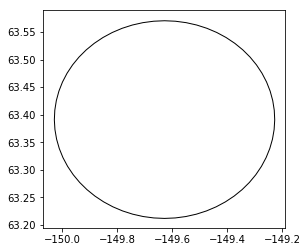


	Record begins 2019-04-01 and ends 2019-06-22 

		 #N21HY_201904011115 expected closest at 2019-04-01 14:02:30 22.3km
		 Flight starting 2019-04-01 11:49:30 was not within the search radius.
		 #N21HY_201906040445 expected closest at 2019-06-04 05:28:07 28.3km
		 Flight starting 2019-06-04 05:25:24 was not within the search radius.
		 #N21HY_201906100630 expected closest at 2019-06-10 07:42:31 20.8km
		 Flight starting 2019-06-10 07:15:03 was not within the search radius.
		 #N21HY_201906130730 expected closest at 2019-06-13 08:03:58 23.7km
		 Flight starting 2019-06-13 08:03:58 was not within the search radius.
		 #N21HY_201906131000 expected closest at 2019-06-13 11:11:32 22.7km
		 Flight starting 2019-06-13 11:06:22 was not within the search radius.
		 #N619CH_201906081230 expected closest at 2019-06-08 12:46:02 22.6km
		 Flight starting 2019-06-08 12:46:02 was not within the search radius.
		 #N619CH_201906091030 expected closest at 2019-06-09 11:19:45 22.7km
		 Flight starting 20

array([], dtype=object)

In [21]:
archive = iyore.Dataset(r"E:\Sound Data") # \\INPDENARENDER

# ============= EDIT THESE ===================================================

# project directory for the current site of interest
project_dir = r"C:\Users\ahug\Documents\NMSim_2014\Data\DENAPRM4"

year = 2019

# ============================================================================

# extract the site name from the project directory path
site = project_dir[-4:]

tracks = tracks_within(archive, site, year, search_within_km = 20, aircraft_specs=False,
                      altOut = project_dir + os.sep + r"Input_Data\03_TRAJECTORY")


# which N-Numbers were observed on this record?
tracks.registration.unique()

In [23]:
tracks

,id,departure_datetime,registration,operator_code,flight_id,submission_method,duration_hrs,landing_datetime,agol_global_id,ticket,...,submission_time,nps_work_group_other,longitude,latitude,knots,heading,altitude_ft,ak_datetime,geom,utc_datetime


In [ ]:



obs_aircraft = {"RUTH":['N8888', 'N72309', 'N619CH', 'N72395', 'N74PS', 'N570AE'],
                "TRLA":['N21HY', 'N709M', 'N473YC', 'N619CH', 'N72309', 'N74PS', 'N570AE'],
                "TEK4":['N21HY', 'N8888', 'N72309', 'N619CH', 'N74PS']}
                    

In [4]:
tracks

,id,departure_datetime,registration,operator_code,flight_id,submission_method,duration_hrs,landing_datetime,agol_global_id,ticket,...,longitude,latitude,knots,heading,altitude_ft,ak_datetime,geom,utc_datetime,closest_time,closest_distance
3994,4347,2019-06-16 18:52:04,N619CH,KAT,N619CH_201906161845,manual,0.94,2019-06-16 19:48:17,None,NaN,...,-149.857,63.5377,118,53,6297,2019-06-16 19:30:04,POINT Z (-149.856573679 63.537692232 6297),2019-06-17 03:30:04,NaN,NaN


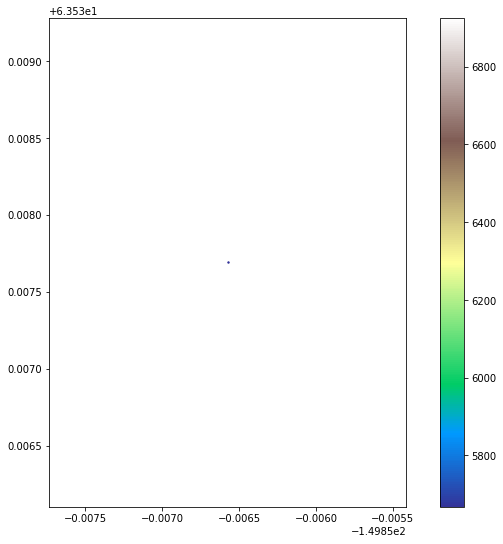

In [3]:
# focal = tracks.loc[tracks.id == 3710, :]

fig, ax = plt.subplots(1, 1, figsize=(12, 9))
tracks.plot(column='altitude_ft', markersize=2, cmap="terrain", ax=ax, legend=True)
plt.show()